<a href="https://colab.research.google.com/github/herysedra/ady_cov/blob/master/scr/modely_RP/R_toam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install pynverse

  Created wheel for pynverse: filename=pynverse-0.1.4.4-cp36-none-any.whl size=6350 sha256=835b1f08ffd40ff8e88e3f2589b7d0073dd2e74cb86f04f7561e69a2118ab22e
  Stored in directory: /root/.cache/pip/wheels/80/ab/86/ec93f37613f012ba3e65c2bbd67e5c54cbc00d237574100c24
Successfully built pynverse


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import matplotlib
import pickle

import datetime
import time
from datetime import date

import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import seaborn as sns

from numpy import log,exp
from numpy.random import multinomial
from scipy.stats import uniform, gamma, gengamma, poisson, nbinom, expon
from scipy.integrate import quad


from mpl_toolkits.mplot3d.axes3d import Axes3D, get_test_data
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from pynverse import inversefunc

tilyvoa = pd.read_csv("/content/drive/My Drive/data/tilyvoa.csv")

mdg_databe = pd.read_csv("/content/drive/My Drive/data/databe mdg.csv")

#tilyvoa.set_index('Daty', inplace=True)

tilyvoafar = tilyvoa.groupby('Faritra')

tilyvoamdg = tilyvoafar.get_group('Madagasikara')
tilyvoamdg.set_index('Daty', inplace=True)
tilyvoamdg.index = pd.to_datetime(tilyvoamdg.index)

tilyvoatana = tilyvoafar.get_group('Antananarivo')
tilyvoatana.set_index('Daty', inplace=True)
tilyvoatana.index = pd.to_datetime(tilyvoatana.index)

tilyvoatoa = tilyvoafar.get_group('Toamasina')
tilyvoatoa.set_index('Daty', inplace=True)
tilyvoatoa.index = pd.to_datetime(tilyvoatoa.index)


path_to_save = '/content/drive/My Drive/sary/'
path_data = '/content/drive/My Drive/data/'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [41]:
# Voa vaovao (observed incidence)
Ivaotoa = tilyvoatoa['Voatomb']

dIvao = pd.DataFrame(data =Ivaotoa)

# Hoan'ny taha sorisoritry ny fifindrana (infectioness profile distribution)

daty_data_manom = datetime.date(2020,6,3)
daty_data_mifar = datetime.date(2020,7,10)

datyt = daty_data_mifar 

format_date = lambda date_py: '{}-{}-{}'.format(date_py.year, date_py.month, date_py.day)
datyf_data_manom = format_date(daty_data_manom)
datyf_data_mifar = format_date(daty_data_mifar)

# Discretization of the serial interval distribution

#Tombana mialoha (prior distributions)
#si_sh = 1/(0.62**2) # Report 13
#si_sc = 6.5/si_sh

si_sh = (6.48**2)/(3.83**2) # Planning tool: Short-term forecasts
si_sc = 6.48/si_sh

def discr_si(t):
  if t == 0:
    discrsi = 0
  elif t == 1:
    discrsi = gengamma.cdf(3/2, si_sh, 1, loc = 0, scale = si_sc)
  else:
    discrsi = gengamma.cdf(t+1/2, si_sh, 1, loc = 0, scale = si_sc) - gengamma.cdf(t-1/2, si_sh, 1, loc = 0, scale = si_sc)
  return discrsi

#discr_si1 = gengamma.cdf(3/2, si_sh, 1, loc = 0, scale = si_sc)

# 1/ The total incidence over a generic window (t-k+1,t)
# Ireh(t,k) = sum(i = 0 to k-1) Ivao(t - i))

def Ireh(t,k):
  Irehv = 0
  if k - 1 > (t - daty_data_manom).days:
    for i in range((t - daty_data_manom).days + 1):
      Irehv = Irehv + dIvao['Voatomb'].loc[format_date(t - datetime.timedelta(days = i))]
  else:
    for i in range(k):
      Irehv = Irehv + dIvao['Voatomb'].loc[format_date(t - datetime.timedelta(days = i))]
  return Irehv

# 2/ Tool to compute the total infectiousness over a generic window (t-k+1,t)
# Isi(t,k) = sum(i=0 to k-1) Ivao(t - i)*discr_si(i)

# The definition of Isi(t,k) does not include the term Ivao(t) for i = 0 (because discr_si(0) =0) 
# so we can start the sum from i = 1; but it includes the last term Ivao(t - k + 1)*discr_si(k - 1) for i = k-1. 

def Isi(t,k):
  Ivaosi = 0
  if k - 1 > (t - daty_data_manom).days:
    for i in range(1, (t - daty_data_manom).days + 1):
      Ivaosi = Ivaosi + dIvao['Voatomb'].loc[format_date(t - datetime.timedelta(days = i))]*discr_si(i)
  else:
    for i in range(1, k):
      Ivaosi = Ivaosi + dIvao['Voatomb'].loc[format_date(t - datetime.timedelta(days = i))]*discr_si(i)
  return Ivaosi

# The total infectiousness before t

# lsi(t) := sum(i=0 to t-1) Ivao(t - i)*discr_si(i)

def lsi(t):
  return Isi(t, (t - daty_data_manom).days +1)

  # for checking, take for example t = daty_data_manom + datetime.timedelta(days = 3)

# 3/ The sum of total infectiousness before t over a generic window (t-k+1,t)
# tlsi(t) := sum(i=t-k+1 to t)lsi(i)

def tlsi(t,k):
  tlsi = 0
  if k - 1 > (t - daty_data_manom).days:
    for i in range((t - daty_data_manom).days + 1):
      tlsi = tlsi + lsi(t - datetime.timedelta(days = i))
  else:
    for i in range(k):
      tlsi = tlsi + lsi(t - datetime.timedelta(days = i))
  return tlsi

# 4/ The shape parameters of the posterior predictive negative binomial of I(t+1)
# pnb(t,k) = lsi(t+1)*Gamma_post_scale(R(t,k))/(1 + lsi(t+1)*Gamma_post_scale(R(t,k)))

def pnb(t,k):
  return lsi(t+datetime.timedelta(days = 1))/(1/si_sc + tlsi(t,k) + lsi(t+datetime.timedelta(days = 1)))

# pnb(t,k) dia ny taha herjika hoan'ny NB hoan'ny I(t+1).

# 5/ Use the pmf of the posterior predictive negative binomial to compute
# each additive contribution at time s then for-loop for s in the time interval

def lpr(t,k):
  return -np.log(nbinom.pmf(dIvao['Voatomb'].loc[format_date(t + datetime.timedelta(days = 1))], si_sh + Ireh(t,k), pnb(t,k)))


In [ ]:
# 6/ Computation of the Accumulated Predictive Error

# APE9_part1 

# for i in range(8):
# t = t_mif - i - 1
# k = 9

APEt91 = []
Prt91 = []

APE91 = 0

for i in range(round(((daty_data_mifar - daty_data_manom).days + 1)/2) - 1):
  t = daty_data_mifar - datetime.timedelta(days = i+1) 
  k = round(((daty_data_mifar - daty_data_manom).days + 1)/2)
  APE91 = APE91 + lpr(t,k)
  APEt91.append((lpr(t,k),t))
  Prt91.append(expon.pdf(lpr(t,k)))

print('For k = 9, APE91 =', APE91)
print('APEt91 =', APEt91)
print('Prt91 =', Prt91)

# APE9_part2 

# for i in range(9):
# t = t_mif - 1 - 9 + 1 - i
# k = t_mif - t - 2*i
APEt92 = []
Prt92 = []

APE92 = 0
for i in range(round(((daty_data_mifar - daty_data_manom).days + 1)/2)-1):
  t = daty_data_mifar - datetime.timedelta(days = 1) - datetime.timedelta(days = ((daty_data_mifar - daty_data_manom).days + 1)/2) + datetime.timedelta(days = 1) - datetime.timedelta(days = i)
  k = (daty_data_mifar - t - datetime.timedelta(days = 2*i)).days
  APE92 = APE92 + lpr(t,k) 
  APEt92.append((lpr(t,k) ,t,k))
  Prt92.append(expon.pdf(lpr(t,k)))

print('For k = 9, APE92 =', APE92)
print('APEt92=', APEt92)
print('Prt92=', Prt92)

# For t_man such that Ivao(t_man) = Ivao(t_man + 1) = 0, lsi(t_man + 1) = tlsi(t_man + 1, 2) = Ireh(t_man + 1, 2) = 0
# so that pnb(t_man + 1, 2) = 0 and 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:100: RuntimeWarning: divide by zero encountered in log


For k = 9, APE91 = inf
APEt91 = [(410.02971799120525, datetime.date(2020, 7, 7)), (463.5575443092304, datetime.date(2020, 7, 6)), (443.1769066198675, datetime.date(2020, 7, 5)), (446.62003702298324, datetime.date(2020, 7, 4)), (453.72755650446345, datetime.date(2020, 7, 3)), (442.71871757071955, datetime.date(2020, 7, 2)), (475.3079687649598, datetime.date(2020, 7, 1)), (499.7217269109926, datetime.date(2020, 6, 30)), (564.1609693071356, datetime.date(2020, 6, 29)), (557.2906328038798, datetime.date(2020, 6, 28)), (708.9052539733219, datetime.date(2020, 6, 27)), (741.606858577325, datetime.date(2020, 6, 26)), (594.6719144599391, datetime.date(2020, 6, 25)), (736.1395433151815, datetime.date(2020, 6, 24)), (717.76526497913, datetime.date(2020, 6, 23)), (inf, datetime.date(2020, 6, 22)), (inf, datetime.date(2020, 6, 21)), (inf, datetime.date(2020, 6, 20))]
Prt91 = [8.440264565408325e-179, 4.780974880323085e-202, 3.394024305102328e-193, 1.0848817749346399e-194, 8.884355387767099e-198, 5.3

In [ ]:
# APEk part 1 for k =/= 9

# for i in range(t_mif - t_man -j)

APEk1 = []
#APEt21 = []
for j in range(2,9):
  APEj1 = 0
  for i in range(round(((daty_data_mifar - daty_data_manom).days) - j)):
    t = daty_data_mifar - datetime.timedelta(days = i+1) 
    k = j
    APEj1 = APEj1 + lpr(t,k)
   # APEt21.append(lpr(t,k))
  APEk1.append(APEj1)

print('APEk1 =', APEk1)
#print('APEt21 =', APEt21)

# APEk part 2 for k =/= 9

Prk2 = []

APEk2 = []

for j in range(2,9):
  APEj2 = 0
  for i in range(j-1):
    t = daty_data_manom + datetime.timedelta(days = j - i - 1)
    k = j - i
    APEj2 = APEj2 + lpr(t,k)
  APEk2.append(APEj2)

print('APEk2 =', APEk2)

APEk1 = [468.7137610460184, 959.1448115721096, 1569.632519084492, 2257.7019001465533, 2983.7256360848205, 3729.4835849037777, 4554.951103558607]
APEk2 = [5.345724154941841, 11.529888595167478, 58.183431720034946, 105.00214150054026, 207.85686275213789, 356.49795829684433, 485.06457693743573]


In [ ]:
# APEk for k = 2,...,8

APEk = [x + y for x, y in zip(APEk1, APEk2)]

# APE9
APE9 = APE91 + APE92

APE = APEk + [APE9]
kk = APE.index(min(APE)) +2
print('APE9 =', APE9)
print('APEk =', APEk)
print('APE =', APE)
print(kk)


APE9 = inf
APEk = [474.05948520096024, 970.674700167277, 1627.815950804527, 2362.7040416470936, 3191.5824988369586, 4085.981543200622, 5040.015680496043]
APE = [474.05948520096024, 970.674700167277, 1627.815950804527, 2362.7040416470936, 3191.5824988369586, 4085.981543200622, 5040.015680496043, inf]
2


# Fifidianana ireo taha mialoha (prior parameters)

In [5]:
kk=2
  #shape
def func_sh(t):
    def Rtpsand_sh(a):
      return a + Ireh(t,kk)
    return Rtpsand_sh
  # Scale
def func_sc(t):
    def Rtpsand_sc(b):
      return 1/(1/b + tlsi(t,kk))
    return Rtpsand_sc

def funcsh_inv(t):
    def sh_invex(x):
      return (x + Ireh(t,kk))/x
    return inversefunc(sh_invex, domain=[0.01, 1e+11])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


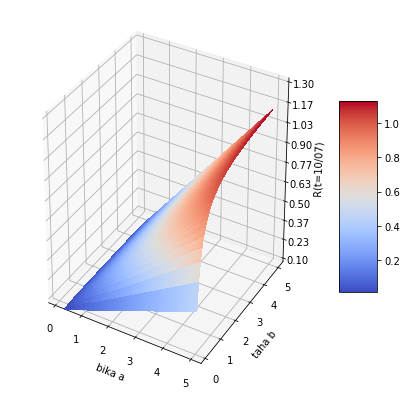

In [7]:
# Variation of R(datyab) with rapport to the prior parameters

datyab = daty_data_mifar

fig = plt.figure(figsize=(7,7))
ax = fig.gca(projection='3d')

# Make data.
X = np.linspace(0.1,5,100)
Y = np.linspace(0.1,5,100)
X, Y = np.meshgrid(X, Y)
Z = func_sh(datyab)(X)*func_sc(datyab)(Y)
W = X*Y
# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
#surf = ax.plot_surface(X, Y, W, cmap=cm.coolwarm,
 #                      linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(0.1, 1.3)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

ax.set(xlabel ='bika a', ylabel = "taha b", zlabel = 'R(t=10/07)')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.savefig(path_to_save+'Rt107_toam.eps')

plt.show()

In [ ]:
# R(t) when equality between the prior and the posterior

# 100 linearly spaced numbers
x = np.linspace(0.1,5,100)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# plot the function
plt.plot(x, x*funcsh_inv(datyab)(x/func_sc(datyab)(x)), 'blue')

ax.set_ylim(0,2)
ax.set(xlabel ='taha', ylabel = "R(t)")


# show the plot
plt.show()

print('taha* = 1')
print('R(t=',datyab,') =', funcsh_inv(datyab)(1/func_sc(datyab)(1)), '= bika*')


# Fanombanana ny R(t) (estimation of R(t))

### Fomba mahazatra

In [ ]:
# shape
def func_sh(t):
    def Rtpsand_sh(a):
      return a + Ireh(t,kk)
    return Rtpsand_sh

# scale
def func_sc(t):
    def Rtpsand_sc(b):
      return 1/(1/b + tlsi(t,kk))
    return Rtpsand_sc


def funcsh_inv(t):
    def sh_invex(x):
      return (x + Ireh(t,kk))/x
    return inversefunc(sh_invex, domain=[1e-11, 1e+11])

# Rt
def Rt_salan(t):
    ffunc_sh = func_sh(t)
    ffunc_sc = func_sc(t)
    ffuncsh_inv = funcsh_inv(t)
    return ffuncsh_inv(1/ffunc_sc(1))

# The 75th and 25th percentiles of Rt

def perc75(t):
    return gengamma.ppf(0.75, func_sh(t)(Rt_salan(t)), 1, loc = 0, scale = func_sc(t)(1))

def perc25(t):
    return gengamma.ppf(0.25, func_sh(t)(Rt_salan(t)), 1, loc = 0, scale = func_sc(t)(1))

def Rtps_sal(t):
  return dIvao['Voatomb'].loc[format_date(t)]/lsi(t)

daty_oh1 = datetime.date(2020,6,25)

print("Kajy mivantana ny R hoan'ny", daty_data_mifar, ':', Rtps_sal(daty_data_mifar))

print("Salan'isa R hoan'ny", daty_oh1, ':', Rt_salan(daty_oh1))
print("Kartily @ 75% R hoan'ny", daty_oh1, ':', perc75(daty_oh1))
print("Kartily @ 25% R hoan'ny", daty_oh1, ':', perc25(daty_oh1))


print("Salan'isa R hoan'ny", daty_data_mifar, ':', Rt_salan(daty_data_mifar))
print("Kartily @ 75% R hoan'ny", daty_data_mifar, ':', perc75(daty_data_mifar))
print("Kartily @ 25% R hoan'ny", daty_data_mifar, ':', perc25(daty_data_mifar))

Kajy mivantana ny R hoan'ny 2020-07-08 : 0.7569661999037133
Salan'isa R hoan'ny 2020-06-25 : 0.1592286628037979
Kartily @ 75% R hoan'ny 2020-06-25 : 0.20723918403687452
Kartily @ 25% R hoan'ny 2020-06-25 : 0.09343143873371408
Salan'isa R hoan'ny 2020-07-08 : 0.5143857245836688
Kartily @ 75% R hoan'ny 2020-07-08 : 0.6638664393973878
Kartily @ 25% R hoan'ny 2020-07-08 : 0.3130854620990444


In [ ]:
# Sampling

np.random.seed(12345)

formatf_date = lambda date_py: '{}/{}'.format(date_py.day, str(date_py.month)[0:1])

daty_lst = []

data_Rt_lst = []

for i in range(round(((daty_data_mifar - daty_data_manom).days) -28)):
  t = daty_data_manom + datetime.timedelta(days = i+1 +28)
  data_amboar = [gengamma.rvs( func_sh(t)(Rt_salan(t)), 1, loc = 0, scale = func_sc(t)(1)) for j in range(1000)]
  daty_lst.append(formatf_date(t))
  data_Rt_lst.append(data_amboar)


### Fomba mifidy a sy b

In [11]:
# Prior Gamma distribution of Rt

Rtpr_sh = 3 # shape
Rtpr_sc =  3 # scale

# Posterior distribution for Rt

# Shape parameter :
def Rtps_sh(t):
   return Rtpr_sh + Ireh(t,kk)

# Scale
def Rtps_sc(t):
  return 1/(1/Rtpr_sc + tlsi(t,kk))

# mean
def Rt_salan(t):
  return Rtps_sh(t)*Rtps_sc(t)

# 75th and 25th percentiles

def perc75(t):
  return gengamma.ppf(0.75, Rtps_sh(t), 1, loc = 0, scale = Rtps_sc(t))

def perc25(t):
  return gengamma.ppf(0.25, Rtps_sh(t), 1, loc = 0, scale = Rtps_sc(t))


def Rtps_sal(t):
  return dIvao['Voatomb'].loc[format_date(t)]/lsi(t)


daty_oh1 = datetime.date(2020,7,2)

print("Kajy mivantana ny R hoan'ny", daty_data_mifar, ':', Rtps_sal(daty_data_mifar))

print("Salan'isa R hoan'ny", daty_oh1, ':', Rt_salan(daty_oh1))
print("Kartily @ 75% R hoan'ny", daty_oh1, ':', perc75(daty_oh1))
print("Kartily @ 25% R hoan'ny", daty_oh1, ':', perc25(daty_oh1))


print("Salan'isa R hoan'ny", daty_data_mifar, ':', Rt_salan(daty_data_mifar))
print("Kartily @ 75% R hoan'ny", daty_data_mifar, ':', perc75(daty_data_mifar))
print("Kartily @ 25% R hoan'ny", daty_data_mifar, ':', perc25(daty_data_mifar))

Kajy mivantana ny R hoan'ny 2020-07-10 : 0.0
Salan'isa R hoan'ny 2020-07-02 : 0.18641186229259488
Kartily @ 75% R hoan'ny 2020-07-02 : 0.24360314966495403
Kartily @ 25% R hoan'ny 2020-07-02 : 0.1073297004067648
Salan'isa R hoan'ny 2020-07-10 : 0.6603253824425102
Kartily @ 75% R hoan'ny 2020-07-10 : 0.8629136632636967
Kartily @ 25% R hoan'ny 2020-07-10 : 0.3801932162304908


In [12]:
# Sampling

np.random.seed(12345)

formatf_date = lambda date_py: '{}/{}'.format(date_py.day, str(date_py.month)[0:1])

daty_lst = []

data_Rt_lst = []

for i in range(round(((daty_data_mifar - daty_data_manom).days) -27)):
  t = daty_data_manom + datetime.timedelta(days = i+1 +27)
  data_amboar = [gengamma.rvs(Rtps_sh(t), 1, loc = 0, scale = Rtps_sc(t)) for j in range(1000)]
  daty_lst.append(formatf_date(t))
  data_Rt_lst.append(data_amboar)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


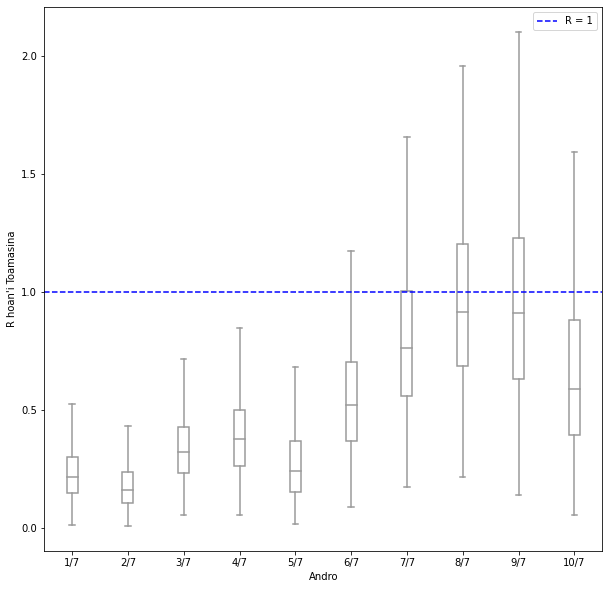

In [13]:
# Plotting the flast 10 days


fig, ax = plt.subplots(figsize=(10, 10))

sns.boxplot(daty_lst, data_Rt_lst, color='white', width=0.2, showfliers=False, ax=ax)
ax.axhline(y=1, color='b', linestyle='dashed', label ="R = 1")

ax.set(xlabel ='Andro', ylabel = "R hoan'i Toamasina")
ax.legend(loc= 'best')

plt.savefig(path_to_save+'Rt3610710_toam.eps')
plt.savefig(path_to_save+'Rt3610710_toam.png')

plt.show()

# Jeritodika ny herinandro

In [23]:
daty_ambaj = datetime.date(2020,7,1)
daty_amboj = datetime.date(2020,7,3)

daty_data_mifarj = datetime.date(2020,7,3)

In [24]:
daty_oh1 = daty_ambaj

print("Tombana ambany: R ",daty_oh1,':',  Rt_salan(daty_oh1))
print("75%-kartily R :",':', perc75(daty_oh1))
print("25%-kartily R :", perc25(daty_oh1))

daty_oh2 = daty_amboj

print("Tombana ambony: R", daty_oh2,':', Rt_salan(daty_oh2))
print("75%-kartily R :",':', perc75(daty_oh2))
print("25%-kartily R :", perc25(daty_oh2))


Tombana ambany: R  2020-07-01 : 0.23483150045804208
75%-kartily R : : 0.299963630703271
25%-kartily R : 0.148843262375525
Tombana ambony: R 2020-07-03 : 0.34393912813654054
75%-kartily R : : 0.43160444479524224
25%-kartily R : 0.23171869595869074


### Ambany

In [25]:
# Computing Ivao(daty_mifarj + i) for i in range(1,8)

daty_m1j = daty_data_mifarj + datetime.timedelta(days = 1)

Rt_amba_hitsiny = 0
Rt_vinaj = Rt_salan(daty_ambaj) + Rt_amba_hitsiny

Iv = int(Rt_vinaj*lsi(daty_m1j))

dIvao.loc[pd.to_datetime(daty_m1j)] =[Iv]

for i in range(1,8):
 tj = daty_m1j + datetime.timedelta(days = i)
 Ivv = int(Rt_vinaj*lsi(tj))
 dIvao.loc[pd.to_datetime(tj)] = [Ivv]

In [26]:
# Plotting the evaluation of the last 7 days

np.random.seed(12345)

formatf_date = lambda date_py: '{}/{}'.format(date_py.day, str(date_py.month)[0:1])

daty_j_lst = []

data_baj = []


for i in range(1,8):
  t = daty_data_mifarj + datetime.timedelta(days = i)
  daty = formatf_date(t)
  datyy = format_date(t)
  data_amboar = [ poisson.rvs(dIvao.loc[datyy]) for j in range(600)]
  daty_j_lst.append(daty)
  data_baj.append(data_amboar)


### Ambony

In [28]:
# Computing Ivao(daty_mifarj + i) for i in range(1,8)

daty_m1j = daty_data_mifarj + datetime.timedelta(days = 1)

# Rt_ambo_hitsiny = (Rt_salan(daty_ambaj) - Rt_salan(daty_amboj))/2

Rt_ambo_hitsiny = 0
Rt_vinaj = Rt_salan(daty_amboj) + Rt_ambo_hitsiny

Iv = int(Rt_vinaj*lsi(daty_m1j))

dIvao.loc[pd.to_datetime(daty_m1j)] =[Iv]

for i in range(1,8):
 tj = daty_m1j + datetime.timedelta(days = i)
 Ivv = int(Rt_vinaj*lsi(tj))
 dIvao.loc[pd.to_datetime(tj)] = [Ivv]

In [ ]:
Rt_vinaj

In [29]:
# Plotting the evaluation of the last 7 days

np.random.seed(12345)

formatf_date = lambda date_py: '{}/{}'.format(date_py.day, str(date_py.month)[0:1])

daty_j_lst = []

data_boj = []


for i in range(1,8):
  t = daty_data_mifarj + datetime.timedelta(days = i)
  daty = formatf_date(t)
  datyy = format_date(t)
  data_amboar = [ poisson.rvs(dIvao.loc[datyy]) for j in range(600)]
  daty_j_lst.append(daty)
  data_boj.append(data_amboar)


### Sary

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


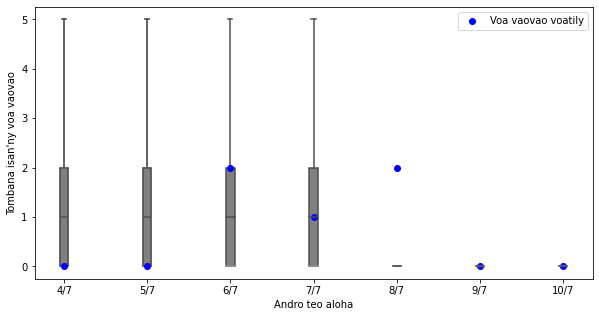

In [31]:
# Plotting the evaluation of the last 7 days

fig, ax = plt.subplots(figsize=(10,5))
box = sns.boxplot(daty_j_lst, data_baj, color='white', width=0.1, showfliers=False, ax=ax)
box = sns.boxplot(daty_j_lst, data_boj, color='grey', width=0.1, showfliers=False, ax=ax)
ax.plot(daty_j_lst, dIvao.loc[pd.to_datetime(daty_m1j):pd.to_datetime(daty_m1j + datetime.timedelta(days = 6))], marker ="o",ls = 'None', color='blue',label="Voa vaovao voatily")
ax.set(xlabel = 'Andro teo aloha', ylabel="Tombana isan'ny voa vaovao")

plt.legend(loc= 'best')

plt.savefig(path_to_save+'Iv47j_toam.eps')
plt.savefig(path_to_save+'Iv47j_toam.png')

plt.show()

## Ny 7 andro manaraka

In [32]:
daty_amba = datetime.date(2020,7,5)
daty_ambo = datetime.date(2020,7,8)


### Vinavina ambany

In [33]:
# Computing Ivao(daty_mifar + i) for i in range(1,8)

daty_m1 = daty_data_mifar + datetime.timedelta(days = 1)

Iv = int(Rt_salan(daty_amba)*lsi(daty_m1))

dIvao.loc[pd.to_datetime(daty_m1)] =[Iv]

for i in range(1,8):
 errt = daty_m1 + datetime.timedelta(days = i)
 Ivv = int(Rt_salan(daty_amba)*lsi(errt))
 dIvao.loc[pd.to_datetime(errt)] =[Ivv]


In [34]:
# Plotting boundaries for the next 7 days

np.random.seed(12345)

formatf_date = lambda date_py: '{}/{}'.format(date_py.day, str(date_py.month)[0:1])

daty_hoav_lst = []

data_amba_hoav = []

Ivv_dat = []

for i in range(1,8):
  t = daty_data_mifar + datetime.timedelta(days = i)
  daty = formatf_date(t)
  datyy = format_date(t)
  data_amboar = [ poisson.rvs(dIvao.loc[datyy]) for j in range(600)]
  daty_hoav_lst.append(daty)
  data_amba_hoav.append(data_amboar)

In [36]:
print('Vinavina ambany')

daty_oh = datetime.date(2020,7,12)

print("Notombanana avy amin'ny R(", daty_amba, '):', Rt_salan(daty_amba)) 
print("Vinavina R hoan'ny", daty_oh, ':', Rt_salan(daty_oh))
print("Vinavina kartily @ 75% R hoan'ny",daty_oh, ':', perc75(daty_oh))
print("Vinavina kartily @ 25% R hoan'ny", daty_oh, ':', perc25(daty_oh))
print("Vinavina isan'ny voa vaovao hoan'ny", daty_oh, ':', dIvao.loc[format_date(daty_oh)])

print("Vinavina kartily @ 75% R hoan'ny", daty_oh, ':', poisson.ppf(0.95, dIvao.loc[format_date(daty_oh)]))
print("Vinavina kartily @ 25% R hoan'ny", daty_oh, ':', poisson.ppf(0.25, dIvao.loc[format_date(daty_oh)]))

Vinavina ambany
Notombanana avy amin'ny R( 2020-07-05 ): 0.27796791643958274
Vinavina R hoan'ny 2020-07-12 : 0.8910486162117373
Vinavina kartily @ 75% R hoan'ny 2020-07-12 : 1.1644229436057767
Vinavina kartily @ 25% R hoan'ny 2020-07-12 : 0.5130359186893183
Vinavina isan'ny voa vaovao hoan'ny 2020-07-12 : Voatomb    0.0
Name: 2020-07-12 00:00:00, dtype: float64
Vinavina kartily @ 75% R hoan'ny 2020-07-12 : [0.]
Vinavina kartily @ 25% R hoan'ny 2020-07-12 : [0.]


### Vinavina ambony

In [38]:
# Computing Ivao(daty_mifar + i) for i in range(1,8)

daty_m1 = daty_data_mifar + datetime.timedelta(days = 1)

Iv = int(Rt_salan(daty_ambo)*lsi(daty_m1))

dIvao.loc[pd.to_datetime(daty_m1)] =[Iv]

for i in range(1,8):
 errt = daty_m1 + datetime.timedelta(days = i)
 Ivv = int(Rt_salan(daty_ambo)*lsi(errt))
 dIvao.loc[pd.to_datetime(errt)] =[Ivv]


In [39]:
# Plotting boundaries for the next 7 days

np.random.seed(12345)

formatf_date = lambda date_py: '{}/{}'.format(date_py.day, str(date_py.month)[0:1])

daty_hoav_lst = []

data_ambo_hoav = []

Ivv_dat = []

for i in range(1,8):
  t = daty_data_mifar + datetime.timedelta(days = i)
  daty = formatf_date(t)
  datyy = format_date(t)
  data_amboar = [ poisson.rvs(dIvao.loc[datyy]) for j in range(600)]
  daty_hoav_lst.append(daty)
  data_ambo_hoav.append(data_amboar)

In [40]:
print('Vinavina ambony')

daty_oh = datetime.date(2020,7,12)

print("Notombanana avy amin'ny R(", daty_ambo, '):', Rt_salan(daty_ambo)) 
print("Vinavina R hoan'ny", daty_oh, ':', Rt_salan(daty_oh))
print("Vinavina kartily @ 75% R hoan'ny",daty_oh, ':', perc75(daty_oh))
print("Vinavina kartily @ 25% R hoan'ny", daty_oh, ':', perc25(daty_oh))
print("Vinavina isan'ny voa vaovao hoan'ny", daty_oh, ':', dIvao.loc[format_date(daty_oh)])

print("Vinavina kartily @ 75% R hoan'ny", daty_oh, ':', poisson.ppf(0.95, dIvao.loc[format_date(daty_oh)]))
print("Vinavina kartily @ 25% R hoan'ny", daty_oh, ':', poisson.ppf(0.25, dIvao.loc[format_date(daty_oh)]))

Vinavina ambony
Notombanana avy amin'ny R( 2020-07-08 ): 0.973230508555929
Vinavina R hoan'ny 2020-07-12 : 1.4686990056906937
Vinavina kartily @ 75% R hoan'ny 2020-07-12 : 1.8430500256161757
Vinavina kartily @ 25% R hoan'ny 2020-07-12 : 0.9894920074908357
Vinavina isan'ny voa vaovao hoan'ny 2020-07-12 : Voatomb    1.0
Name: 2020-07-12 00:00:00, dtype: float64
Vinavina kartily @ 75% R hoan'ny 2020-07-12 : [3.]
Vinavina kartily @ 25% R hoan'ny 2020-07-12 : [0.]


### Sary

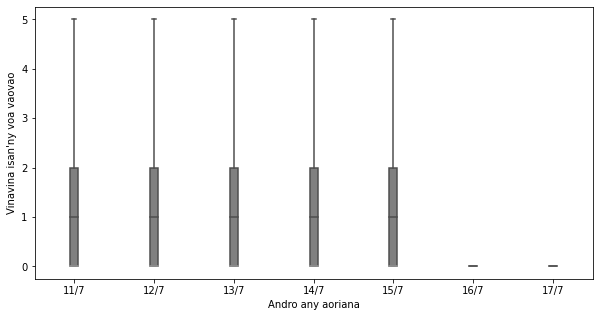

In [43]:
# Plotting boundaries for the next 7 days

fig, ax = plt.subplots(figsize=(10,5))
box = sns.boxplot(daty_hoav_lst, data_amba_hoav, color='white', width=0.1, showfliers=False, ax=ax)
box = sns.boxplot(daty_hoav_lst, data_ambo_hoav, color='grey', width=0.1, showfliers=False, ax=ax)

ax.set_xlabel('Andro any aoriana')
ax.set_ylabel("Vinavina isan'ny voa vaovao")

plt.savefig(path_to_save+'Iv107hoav_toam.eps')
plt.savefig(path_to_save+'Iv107hoav_toam.png')

plt.show()